In [820]:
import pandas as pd
import geopandas as gpd
import numpy as np
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits

In [823]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/Salim/Desktop/housing-elements/housing_elements/utils.py'>

In [742]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [743]:
# Oakland and Palo Alto don't work right now (parsing certain columns as floats fails)
cities = ['San Francisco', 'Berkeley', 'Mountain View', 'San Jose']

In [817]:
df = gpd.read_file(
        "./data/raw_data/housing_sites/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp"
    )

In [745]:
all_cities = df.jurisdict.unique()

In [746]:
len(all_cities)

108

In [747]:
%%time
cities_with_sites = {}

for city in all_cities:
    try:
        with HiddenPrints():
            cities_with_sites[city] = utils.load_site_inventory(city)
            cities_with_sites[city].relcapcty.sum()
    except Exception:
        pass

CPU times: user 4min 45s, sys: 5.49 s, total: 4min 50s
Wall time: 4min 48s


In [748]:
len(cities_with_sites)

108

In [780]:
%%time
cities_with_permits = {}

for city in all_cities:
    try:
        with HiddenPrints():
            cities_with_permits[city] = utils.load_all_new_building_permits(city)
    except Exception:
        pass

CPU times: user 4min 16s, sys: 1.37 s, total: 4min 17s
Wall time: 4min 19s


In [781]:
len(cities_with_permits)

98

In [782]:
def get_results_for_city(city: str, merge_with_address: bool = False) -> pd.DataFrame:
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits, merge_with_address),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits, merge_with_address),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits, merge_with_address),
    }

In [783]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [785]:
len(cities)

98

In [632]:
%%time
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city) for city in cities])

CPU times: user 8min 8s, sys: 7.29 s, total: 8min 15s
Wall time: 8min 13s


(array([79., 12.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

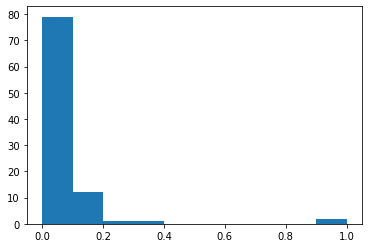

In [761]:
from matplotlib import pyplot as plt
plt.hist(results_df['P(dev) for inventory'])

In [787]:
results_df[(results_df['P(dev) for inventory'] == 1)]

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory
18,San Francisco,0.552246,-40270.0,0.266158,1.0,1.0,1.0
56,Colma,2.884615,40.0,0.880000,1.0,NaN,1.0


In [788]:
cities_with_sites['Colma']

,objectid,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,...,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry
33111,75245,RHNA5,2015-2023,6081,Colma,11370220,11370220,Commercial,C,3.319,...,Y,"Topography, narrow and triangular site, existi...",NaN,Y,NaN,Mostly Vacant,NaN,0.000001,0.00742,"POLYGON ((-122.45159 37.67198, -122.45006 37.6..."


In [794]:
cities_with_permits['San Francisco'][cities_with_permits['San Francisco']['apn'] == 11370220.0].totalunit

12    66
Name: totalunit, dtype: int64

In [773]:
utils.load_all_new_building_permits("Albany")

,objectid,joinid,permyear,county,jurisdictn,apn,address,zip,projname,hcategory,...,Building Permits Date Issued,How many of the units were Extremely Low Income?+,Was Project APPROVED using GC 65913.4(b)? (SB 35 Streamlining) Y/N,Infill Units? Y/N+,Deed Restriction Type (see instructions),"For units affordable without financial assistance or deed restrictions, explain how the locality determined the units were affordable (see instructions)",Term of Affordability or Deed Restriction (years) (if affordable in perpetuity enter 1000)+,Number of Demolished/Destroyed Units+,Demolished or Destroyed Units+,Demolished/Destroyed Units Owner or Renter+
0,NaN,6d974f6a-726c-11e8-adc0-fa7ae01bbebc,2017,6001.0,Albany,6.628100e+10,728 Cornell,94706,(N) SFD + attached ADU,SF,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,6d975140-726c-11e8-adc0-fa7ae01bbebc,2017,6001.0,Albany,6.728520e+10,710 San Carlos,94706,(N) detached ADU,SU,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,6d975604-726c-11e8-adc0-fa7ae01bbebc,2017,6001.0,Albany,6.628100e+10,707 Stannage,94706,Addn & remod to access bldg to convert to ADU,SU,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,6d97588e-726c-11e8-adc0-fa7ae01bbebc,2017,6001.0,Albany,6.728660e+10,508 Ramona,94706,(N) detached ADU,SU,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,6d975a96-726c-11e8-adc0-fa7ae01bbebc,2017,6001.0,Albany,6.524120e+10,1065 Curtis,94706,(N) detached ADU,SU,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,2018,NaN,NaN,6.627270e+10,935 FILLMORE ST,NaN,NaN,ADU,...,2018-04-30,NaN,N,NaN,NaN,Survey of comparable units,NaN,NaN,NaN,NaN
76,NaN,NaN,2017,NaN,NaN,6.526260e+10,908 ORDWAY ST,NaN,NaN,ADU,...,2017-12-18,NaN,N,NaN,NaN,Survey of comparable units,NaN,NaN,NaN,NaN
77,NaN,NaN,2017,NaN,NaN,6.524080e+10,1128 TALBOT AVE,NaN,NaN,ADU,...,2017-10-06,NaN,N,NaN,NaN,Survey of comparable units,NaN,NaN,NaN,NaN
78,NaN,NaN,2018,NaN,NaN,6.627890e+10,848 MADISON ST,NaN,NaN,ADU,...,2018-02-14,NaN,N,NaN,NaN,Survey of comparable units,NaN,NaN,NaN,NaN


In [44]:
%%time
results_geo_df = pd.DataFrame([get_results_for_city(city, merge_with_address=True) for city in cities])

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Dropping constant columns: ['rhnacyc' 'rhnayrs' 'county' 'jurisdict' 'currunits' 'allowlow' 'num_vl'
 'num_l' 'num_m' 'num_am']
DF shape (6158, 16)
Total units permitted: 26071
Total realistic capacity in inventory: 47209.0
Number of inventory sites developed: 0
Number of units permitted on inventory sites: 0
Total realistic capacity of inventory sites: 0.0
Units permitted on inventory sites: 0
Total units permitted: 26071


/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py:299: RuntimeWarning: invalid value encountered in double_scalars
  return (n_units - n_claimed) / len(inventory_sites_permitted)
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Dropping constant columns: ['rhnacyc' 'rhnayrs' 'county' 'jurisdict' 'currunits' 'allowlow' 'num_vl'
 'num_l' 'num_m' 'num_am']
DF shape (404, 18)
Total units permitted: 1871
Total realistic capacity in inventory: 5372.02
Number of inventory sites developed: 0
Number of units permitted on inventory sites: 0
Total realistic capacity of inventory sites: 0.0
Units permitted on inventory sites: 0
Total units permitted: 1871


/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py:299: RuntimeWarning: invalid value encountered in double_scalars
  return (n_units - n_claimed) / len(inventory_sites_permitted)
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Dropping constant columns: ['rhnacyc' 'rhnayrs' 'county' 'jurisdict' 'num_vl' 'num_l' 'num_m'
 'num_am']
DF shape (93, 24)
Total units permitted: 3579.0
Total realistic capacity in inventory: 3216.0
Number of inventory sites developed: 3
Number of units permitted on inventory sites: 426.0
Total realistic capacity of inventory sites: 799.0
Units permitted on inventory sites: 426.0
Total units permitted: 3579.0


/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Dropping constant columns: ['rhnacyc' 'rhnayrs' 'county' 'jurisdict' 'currunits' 'allowlow' 'num_vl'
 'num_l' 'num_m' 'num_am']
DF shape (599, 18)
Total units permitted: 16928.0
Total realistic capacity in inventory: 35536.43
Number of inventory sites developed: 64
Number of units permitted on inventory sites: 3473.0
Total realistic capacity of inventory sites: 3664.0
Units permitted on inventory sites: 3473.0
Total units permitted: 16928.0
CPU times: user 55.1 s, sys: 1.27 s, total: 56.3 s
Wall time: 57 s


In [45]:
results_geo_df

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory
0,San Francisco,0.552246,NaN,0.000000,0.074924,0.075974,0.075187
1,Berkeley,0.348286,NaN,0.000000,0.029940,0.033755,0.032178
2,Mountain View,1.112873,-124.333333,0.119028,0.186047,0.285714,0.193548
3,San Jose,0.476356,-2.984375,0.205163,0.236641,0.126214,0.198664


In [667]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }

In [756]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco', 'San Jose']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

Dropping constant columns: ['county', 'num_vl', 'rhnayrs', 'rhnacyc', 'infcapcty', 'allowlow', 'jurisdict', 'num_m', 'num_am', 'num_l']
DF shape (57, 25)
Total units permitted: 532
Total realistic capacity in inventory: 257.5
Number of inventory sites developed: 9
Number of units permitted on inventory sites: 34
Total realistic capacity of inventory sites: 38.0
Units permitted on inventory sites: 34
Total units permitted: 532


/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (18,22,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  
/Users/Salim/Desktop/housing-elements/housing_elements/san_francisco_permits.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ]


Dropping constant columns: ['county', 'num_vl', 'rhnayrs', 'rhnacyc', 'currunits', 'allowlow', 'jurisdict', 'num_m', 'num_am', 'num_l']
DF shape (6158, 25)
Total units permitted: 26071
Total realistic capacity in inventory: 47209.0
Number of inventory sites developed: 1
Number of units permitted on inventory sites: 6939
Total realistic capacity of inventory sites: 47209.0
Units permitted on inventory sites: 6939
Total units permitted: 26071
Dropping constant columns: ['county', 'num_vl', 'rhnayrs', 'rhnacyc', 'currunits', 'allowlow', 'jurisdict', 'num_m', 'num_am', 'num_l']
DF shape (599, 25)
Total units permitted: 16928.0
Total realistic capacity in inventory: 35536.43
Number of inventory sites developed: 67
Number of units permitted on inventory sites: 5011.0
Total realistic capacity of inventory sites: 6422.0
Units permitted on inventory sites: 5011.0
Total units permitted: 16928.0
CPU times: user 29.3 s, sys: 1.39 s, total: 30.7 s
Wall time: 1min 21s


In [757]:
ground_truth_results_df

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory
0,Los Altos,2.066019,-0.444444,0.063910,0.088235,0.260870,0.157895
1,San Francisco,0.552246,-40270.000000,0.266158,1.000000,1.000000,1.000000
2,San Jose,0.476356,-21.059701,0.296018,0.134860,0.067961,0.111853
